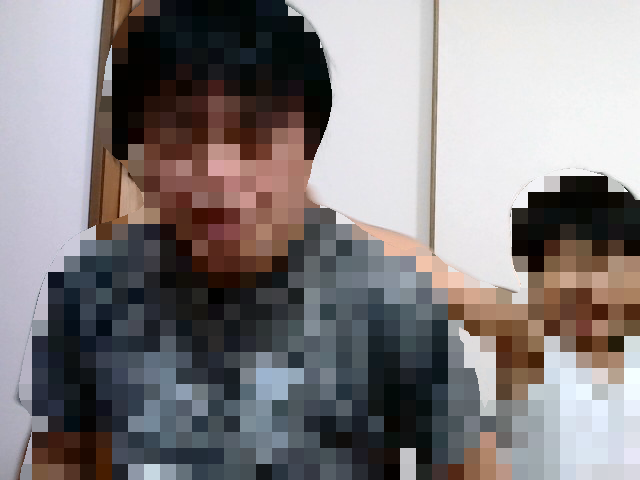

KeyboardInterrupt: 

In [2]:

# Import required libraries
import torch
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import PIL.Image
from io import BytesIO
import sounddevice as sd
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.transforms import functional as F

# Load the DeepLabV3 model with pre-trained weights
model = deeplabv3_resnet101(pretrained=True)
model = model.cpu()  # Run model on CPU
model.eval()

# Parameters
mosaic_level = 16  # Adjust mosaic level as desired

# Function to apply mosaic effect
def apply_mosaic(frame):
    frame_mosaic = cv2.resize(frame, (frame.shape[1] // mosaic_level, frame.shape[0] // mosaic_level),
                              interpolation=cv2.INTER_NEAREST)
    frame_mosaic = cv2.resize(frame_mosaic, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return frame_mosaic

# Function to generate a face mask using DeepLabV3
def generate_face_mask(frame):
    image = F.to_tensor(frame).unsqueeze(0)
    with torch.no_grad():
        output = model(image)['out']
    output_predictions = output.argmax(1).squeeze().cpu().numpy()
    mask = output_predictions == 15  # 15 is the label for 'person' in COCO
    mask = mask.astype(np.uint8) * 255
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask_resized

# Function to display frame within Jupyter Notebook
def display_frame(frame):
    img_pil = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_buf = BytesIO()
    img_pil.save(img_buf, format='png')
    img_buf.seek(0)
    img_b64 = Image(data=img_buf.read(), format='png', embed=True)
    display(img_b64)

# Initialize webcam
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Generate a mask for the detected human
        mask = generate_face_mask(frame)

        # Apply mosaic to the detected human
        mosaic_frame = apply_mosaic(frame)
        frame = np.where(mask[..., None], mosaic_frame, frame)

        # Display the frame in the Jupyter Notebook
        clear_output(wait=True)
        display_frame(frame)
        
        # Quit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()


In [ ]:

# Import required libraries
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
import PIL.Image
from io import BytesIO
import sounddevice as sd
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.transforms import functional as F

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the DeepLabV3 model with pre-trained weights
model = deeplabv3_resnet101(pretrained=True)
model = model.to(device)  # Move model to GPU if available
model.eval()

# Parameters
mosaic_level = 16  # Adjust mosaic level as desired

# Function to apply mosaic effect
def apply_mosaic(frame):
    frame_mosaic = cv2.resize(frame, (frame.shape[1] // mosaic_level, frame.shape[0] // mosaic_level),
                              interpolation=cv2.INTER_NEAREST)
    frame_mosaic = cv2.resize(frame_mosaic, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return frame_mosaic

# Function to generate a face mask using DeepLabV3
def generate_face_mask(frame):
    image = F.to_tensor(frame).unsqueeze(0).to(device)  # Move tensor to GPU if available
    with torch.no_grad():
        output = model(image)['out']
    output_predictions = output.argmax(1).squeeze().cpu().numpy()
    mask = output_predictions == 15  # 15 is the label for 'person' in COCO
    mask = mask.astype(np.uint8) * 255
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask_resized

# Function to display frame within Jupyter Notebook
def display_frame(frame):
    img_pil = PIL.Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_buf = BytesIO()
    img_pil.save(img_buf, format='png')
    img_buf.seek(0)
    img_b64 = Image(data=img_buf.read(), format='png', embed=True)
    display(img_b64)

# Initialize webcam
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Generate a mask for the detected human
        mask = generate_face_mask(frame)

        # Apply mosaic to the detected human
        mosaic_frame = apply_mosaic(frame)
        frame = np.where(mask[..., None], mosaic_frame, frame)

        # Display the frame in the Jupyter Notebook
        clear_output(wait=True)
        display_frame(frame)
        
        # Quit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
